## Importing Libraries

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Importing the Data

In [2]:
df_listings = pd.read_pickle('../data/processed/df_listings.pkl')

## Data Modeling

### What features assist in the pricing of a listing? 
- Could the price be predicted?
- importance of the features, rank features

### Preparing data

In [3]:
pd.set_option('display.max_columns', None)

df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,1.0,0.90,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1.0,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",105.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,1.0,0.75,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1.0,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",40.0,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,1.00,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1.0,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",75.0,10,50,10.0,10.0,50.0,50.0,10.0,50.0,NaN,t,29,59,62,189,202

In [4]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71823 entries, 0 to 71822
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            71823 non-null  int64  
 1   listing_url                                   71823 non-null  object 
 2   scrape_id                                     71823 non-null  int64  
 3   last_scraped                                  71823 non-null  object 
 4   name                                          71800 non-null  object 
 5   description                                   68994 non-null  object 
 6   neighborhood_overview                         43797 non-null  object 
 7   picture_url                                   71823 non-null  object 
 8   host_id                                       71823 non-null  int64  
 9   host_url                                      71823 non-null 

#### Removing Features

In [5]:
def drop_columns(df):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','scrape','first_review','last_review','cancellation_policy', 'maximum', 
                  'minimum', 'host','requires']
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['name','description','neighborhood_overview','latitude',
                          'longitude','neighbourhood','calendar_updated'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

df_listings = drop_columns(df_listings)

In [6]:
#df = df[df['bathrooms_text'].notna()]
df_listings.rename(columns={'bathrooms_text': 'bathrooms_shared'}, inplace=True)

#### Feature Engineering

<AxesSubplot:>

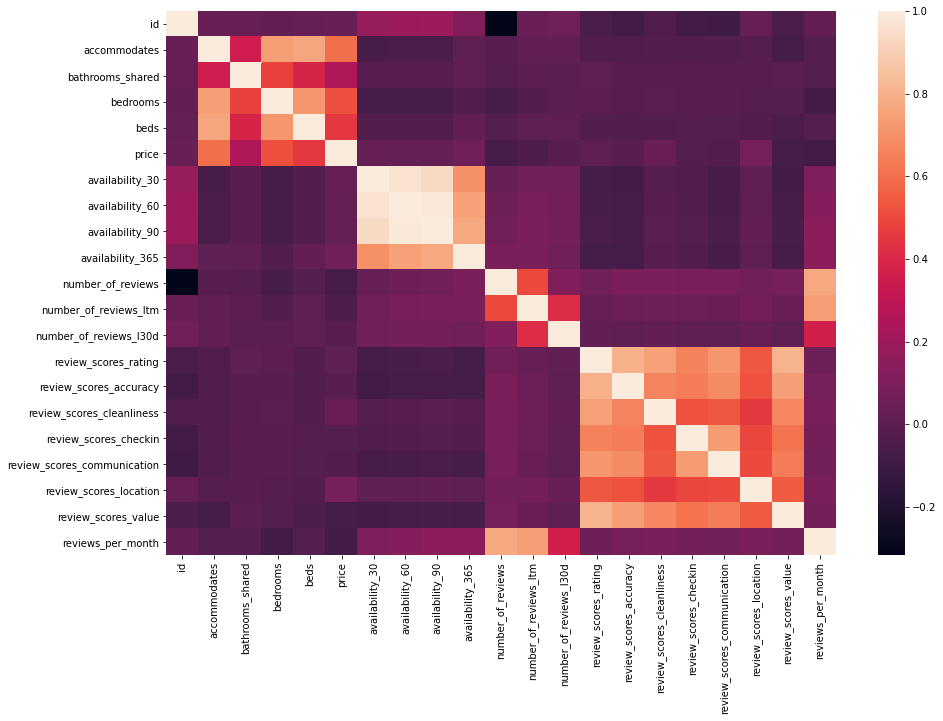

In [7]:
# calculate the correlation matrix
corr = df_listings.corr()

plt.figure(figsize = (15,10))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [8]:
#df_listings = df_listings[['neighbourhood_cleansed','property_type', 'room_type', 'bathrooms_shared', 
#             'has_availability','instant_bookable', 'bedrooms', 'beds', 'amenities','price']]

In [9]:
for col in df_listings.select_dtypes(include=['object']).columns:
    print(col, ': ', len(df_listings[col].unique()), 'labels')

neighbourhood_cleansed :  33 labels
property_type :  89 labels
room_type :  4 labels
amenities :  67099 labels
has_availability :  2 labels
instant_bookable :  2 labels


In [10]:
# Renaming property types to other where their total count is less than 100
counts = df_listings['property_type'].value_counts()

df_listings['property_type'] = np.where(df_listings['property_type'].isin(counts.index[counts >= 30]), 
                                        df_listings['property_type'], 'Other')

In [11]:
df_listings["amenities"] = df_listings["amenities"].apply(eval)

In [12]:
df_listings["amenities"].head()

0    [Refrigerator, Kitchen, Crib, Dedicated worksp...
1    [Long term stays allowed, Lock on bedroom door...
2    [Refrigerator, Wifi, Heating, Dishes and silve...
3    [TV, Hair dryer, Lock on bedroom door, Carbon ...
4    [Iron, Coffee maker, Essentials, Kitchen, Hang...
Name: amenities, dtype: object

In [13]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

df_amenities_top_20 = pd.DataFrame(to_1D(df_listings["amenities"]).value_counts().head(20)).index

In [14]:
list(df_amenities_top_20)

['Wifi',
 'Heating',
 'Essentials',
 'Kitchen',
 'Smoke alarm',
 'Washer',
 'Hangers',
 'Iron',
 'TV',
 'Hair dryer',
 'Shampoo',
 'Dedicated workspace',
 'Carbon monoxide alarm',
 'Hot water',
 'Dryer',
 'Refrigerator',
 'Dishes and silverware',
 'Cooking basics',
 'Oven',
 'Bed linens']

In [15]:
def onehot_df(df, variable, unique_items):
    
    item_lists = df[variable]
    
    # Loop through all the labels
    for i, label in enumerate(unique_items):
        
        # Creating new column for each label
        df[variable+'_'+label] = item_lists.apply(lambda x: 1 if label in x else 0)
    
    # Removing old column
    del df[variable]
            
    # Return the results as a dataframe
    return df

In [16]:
onehot_df(df_listings,"amenities", list(df_amenities_top_20))

,id,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_shared,bedrooms,beds,price,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,amenities_Wifi,amenities_Heating,amenities_Essentials,amenities_Kitchen,amenities_Smoke alarm,amenities_Washer,amenities_Hangers,amenities_Iron,amenities_TV,amenities_Hair dryer,amenities_Shampoo,amenities_Dedicated workspace,amenities_Carbon monoxide alarm,amenities_Hot water,amenities_Dryer,amenities_Refrigerator,amenities_Dishes and silverware,amenities_Cooking basics,amenities_Oven,amenities_Bed linens
0,11551,Lambeth,Entire apartment,Entire home/apt,4,1.0,1.0,3.0,105.0,t,3,33,63,338,192,6,0,91.0,9.0,9.0,10.0,10.0,9.0,9.0,t,1.46,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0
1,13913,Islington,Private room in apartment,Private room,2,1.0,1.0,0.0,40.0,t,30,60,90,365,21,1,0,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,0.17,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,15400,Kensington and Chelsea,Entire apartment,Entire home/apt,2,1.0,1.0,1.0,75.0,t,29,59,62,189,89,1,0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,t,0.66,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0
3,17506,Hammersmith and Fulham,Private room in townhouse,Private room,2,1.0,1.0,1.0,150.0,t,29,59,89,364,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
4,25123,Barnet,Private room in house,Private room,2,1.5,1.0,0.0,29.0,t,0,0,0,2,129,3,0,96.0,10.0,10.0,10.0,10.0,9.0,10.0,t,0.99,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71818,47065798,Camden,Entire condominium,Entire home/apt,1,1.5,1.0,0.0,52.0,t,10,40,66,66,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN,1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0
71819,47065799,Lewisham,Entire house,Entire home/apt,4,1.0,2.0,2.0,111.0,t,27,57,87,87,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1
71820,47065881,Westminster,Entire condominium,Entire home/apt,4,1.0,2.0,2.0,189.0,t,30,60,90,363,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0
71821,47066182,Camden,Entire condominium,Entire home/apt,2,1.0,NaN,1.0,149.0,t,27,57,87,346,1,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,1.00,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0


In [17]:
# Confirming the shape of the df_listings
df_listings.shape

(71823, 46)

In [18]:
# Removing any rows with NaN values
df_listings = df_listings.dropna()

In [19]:
# Confirming there are no rows with NaN values
df_listings.isnull().sum()

id                                 0
neighbourhood_cleansed             0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_shared                   0
bedrooms                           0
beds                               0
price                              0
has_availability                   0
availability_30                    0
availability_60                    0
availability_90                    0
availability_365                   0
number_of_reviews                  0
number_of_reviews_ltm              0
number_of_reviews_l30d             0
review_scores_rating               0
review_scores_accuracy             0
review_scores_cleanliness          0
review_scores_checkin              0
review_scores_communication        0
review_scores_location             0
review_scores_value                0
instant_bookable                   0
reviews_per_month                  0
amenities_Wifi                     0
a

In [20]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df_listings = df_listings[df_listings['price'] != 0]

#### Train / Test split

In [21]:
# Extract features and labels
X = df_listings.drop("price", axis=1) # drop labels for training set
y = df_listings["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37337, 45)
(9335, 45)
(37337,)
(9335,)


In [24]:
X_train_num = X_train.select_dtypes(include=['float', 'int'])
X_train_cat = X_train.select_dtypes(include=['object'])

#### Data selector 

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return X[self.attribute_names]

#### Creating the Pipeline

In [26]:
num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

In [27]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore')),
    ])

In [28]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

In [29]:
from sklearn.pipeline import FeatureUnion

full_pipeline = Pipeline([
       ('features', FeatureUnion([
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)
                ])
        )])

In [30]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [31]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(37337, 117)
(9335, 117)


## Model Evaluation

### Base Evaluation - Fittng the training data with various models

In [32]:
def base_models(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, predict_train)
    mse_test = mean_squared_error(y_test, predict_test)
    
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    print("RMSE: Train data " + str(round(rmse_train,2)))
    print("RMSE: Test data " + str(round(rmse_test,2)))

In [33]:
# Linear Regression - Base Model
lm = LinearRegression(n_jobs=4)
base_models(lm, X_train_prepared, X_test_prepared, y_train, y_test)

RMSE: Train data 32.64
RMSE: Test data 32.75


In [ ]:
# Ridge Regression - Base Model
ridge = Ridge()
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(n_jobs=4,random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Gradient Boosting Regressor - Base Model
grad_booreg = GradientBoostingRegressor(random_state=42)
base_models(grad_booreg, X_train_prepared, X_test_prepared, y_train, y_test)

### Fine tune the model with cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

def display_scores(model, X_train, y_train):
    
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
    
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("Standard deviation of RMSE scores:", rmse_scores.std())

In [ ]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

In [ ]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

In [ ]:
# Gradient Boosting Regressor - CV Model
display_scores(grad_booreg, X_train_prepared, y_train)

### Comparing the Train and Test scores

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
# Ridge Regression:
title = r"Learning Curves for Ridge Regression"
estimator = Ridge(alpha=0.1, normalize=True)
plot_learning_curve(estimator, title, X_train_prepared, y_train, cv=5, n_jobs=-1)

# Random Forest Regression:
title = r"Learning Curves for Random Forest Regression"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=-1)

# Gradient Boosting Regressor:
title = r"Learning Curves for Gradient Boosting Regressor"
estimaGradientBoostingRegressor= GradientBoostingRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=-1)

plt.show()

### Fine tunning the model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [500]}
  ]

ranfor2 = RandomForestRegressor(n_jobs=-1,random_state=42)

grid_search = GridSearchCV(ranfor2, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)

grid_search.fit(X_train_prepared, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
y_pred = grid_search.predict(X_test_prepared)

In [ ]:
mse = mean_squared_error(y_test,y_pred)

In [ ]:
rmse = np.sqrt(mse)

In [ ]:
rmse